# Benchmark on Gaussian or Box Blur

In [125]:
import d3dshot
import torch
import time
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn.functional as F
import timeit

In [2]:
d = d3dshot.create(capture_output="pytorch_float_gpu")

In [3]:
#high-speed screen capture
d.capture(region=(0, 0, 1920, 1080))

True

In [4]:
image = d.get_latest_frame()

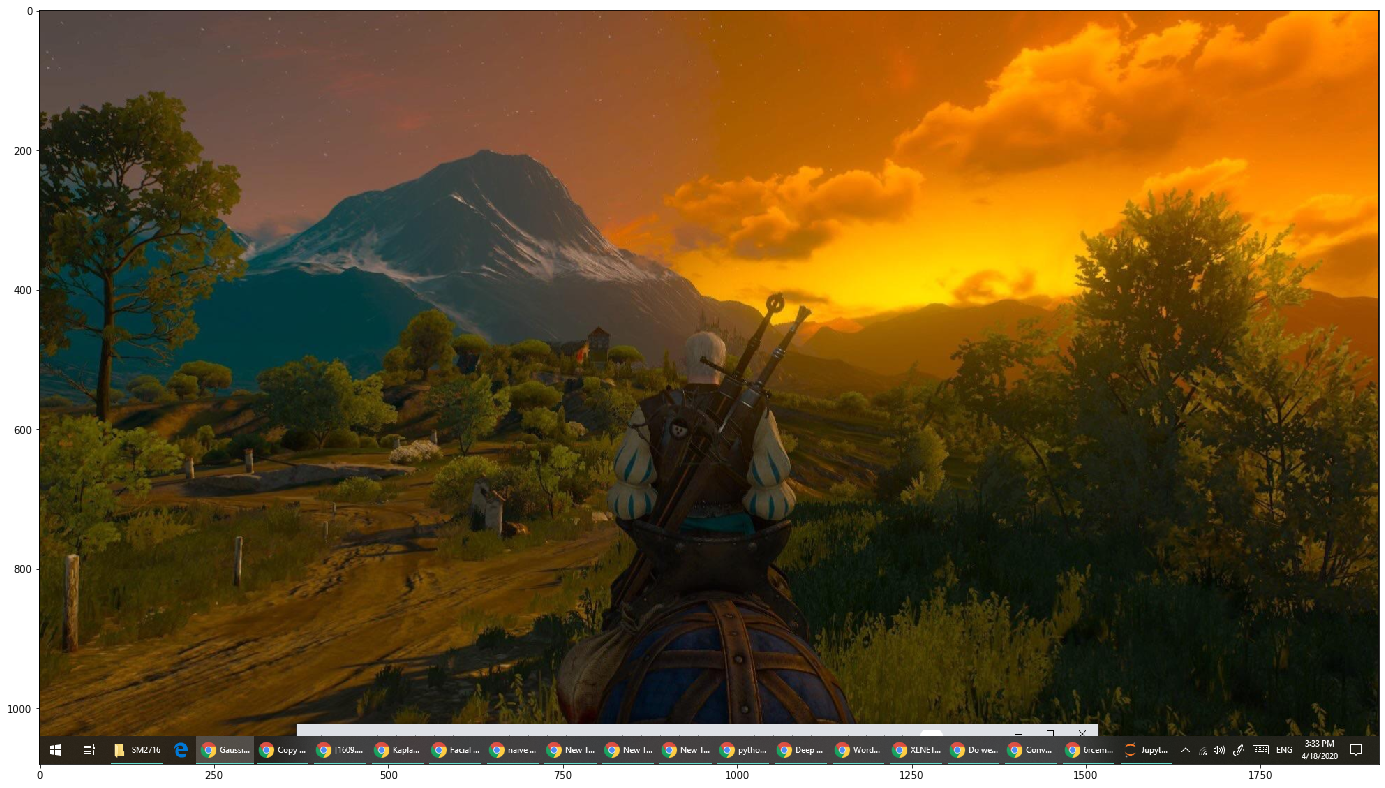

In [5]:
plt.figure(figsize=(24,16))
plt.imshow(image.cpu())
plt.show()

In [6]:
image.shape

torch.Size([1080, 1920, 3])

In [210]:
def benchmark(func, number, frame=60):
    total = 0
    for _ in range(number):
        start = time.perf_counter()
        for _ in range(frame):
            eval(func)
        diff = time.perf_counter() - start
        total += diff
        print(f'Took {diff}s')
    print(f'Totally: {total}s')
    print(f'Avg: {total/number}s')

In [139]:
def downsample(tensor, size=(32, 59), mode='area'):
    """source tensor should be in 3D (H, W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    return F.interpolate(
        tensor.permute(2, 0, 1).unsqueeze(0), size=size, mode=mode
    ).squeeze(0).permute(1, 2, 0)  # back to (H, W, C), for imshow right now

In [212]:
benchmark('downsample(image)', 10)

Took 5.452369499998895s
Took 5.682056400000874s
Took 5.73834220000208s
Took 5.481101699999272s
Took 5.278516100002889s
Took 5.4195841000000655s
Took 5.226640900000348s
Took 5.49088539999866s
Took 5.439254000000801s
Took 5.421915300001274s
Totally: 54.63066560000516s
Avg: 5.463066560000516s


In [213]:
benchmark("downsample(image, mode='bilinear')", 10)

Took 5.447965999999724s
Took 5.610735800000839s
Took 5.298018499997852s
Took 5.440700699997251s
Took 5.639074500002607s
Took 5.661410299999261s
Took 5.552187799999956s
Took 5.248997700000473s
Took 5.5539804s
Took 5.788015199999791s
Totally: 55.241086899997754s
Avg: 5.524108689999776s


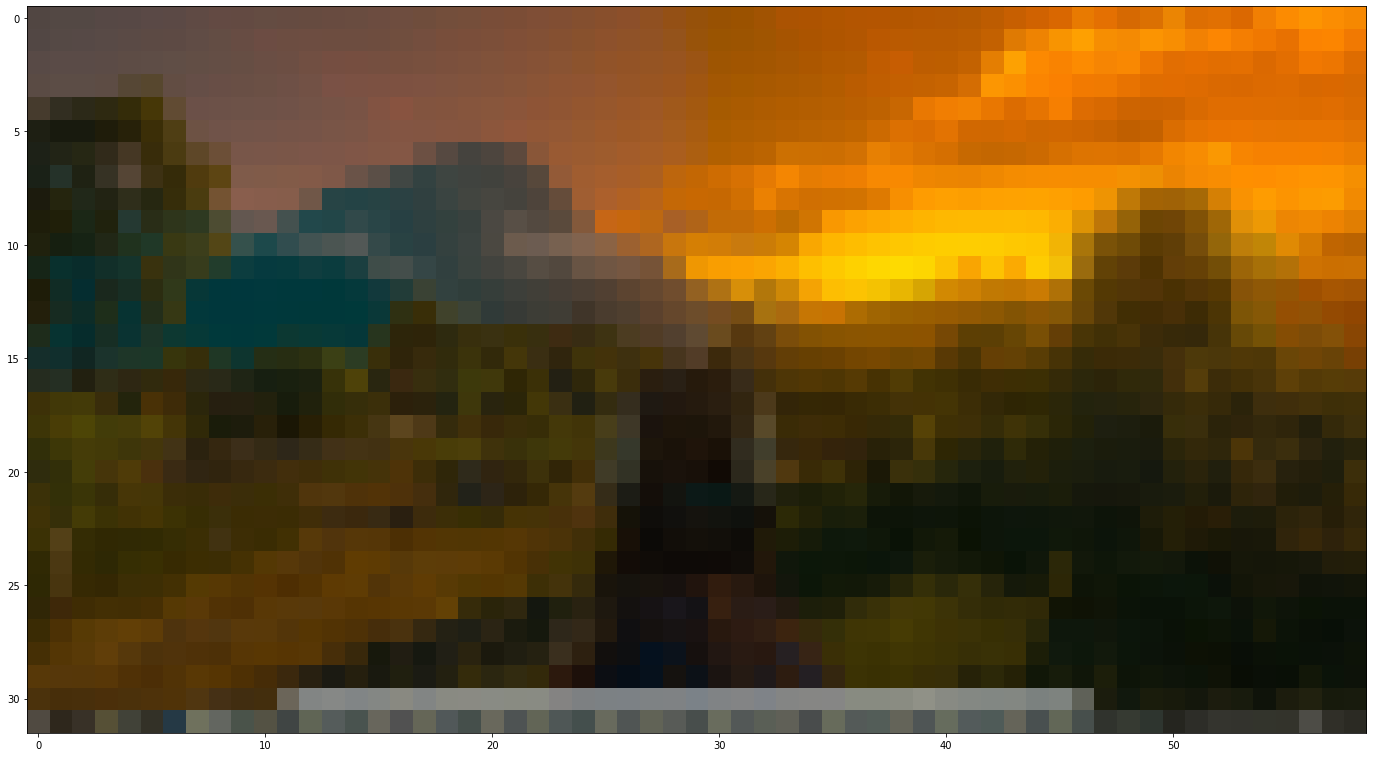

In [292]:
# area
image_r = downsample(image)
plt.figure(figsize=(24,16))
plt.imshow(image_r.cpu())
plt.show()

# Downsample by ? and upsample to fixed size

In [35]:
def downupsample(tensor, scale, size=(32,59)):
    """source tensor should be in 3D (H, W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    downsampled = F.interpolate(tensor.permute(2, 0, 1).unsqueeze(0), scale_factor=scale, mode='area')
    return F.interpolate(
        downsampled, size=size, mode='bilinear', align_corners=False
    ).squeeze(0).permute(1, 2, 0)  # back to (H, W, C), for imshow right now

In [214]:
benchmark("downupsample(image, 0.02)", 10)

Took 7.035974100002932s
Took 7.203889500000514s
Took 7.1415529000005336s
Took 7.175457199999073s
Took 7.181711000001087s
Took 7.192932199999632s
Took 7.319818600000872s
Took 7.181498599999031s
Took 7.091246899999533s
Took 7.167653900000005s
Totally: 71.69173490000321s
Avg: 7.169173490000321s


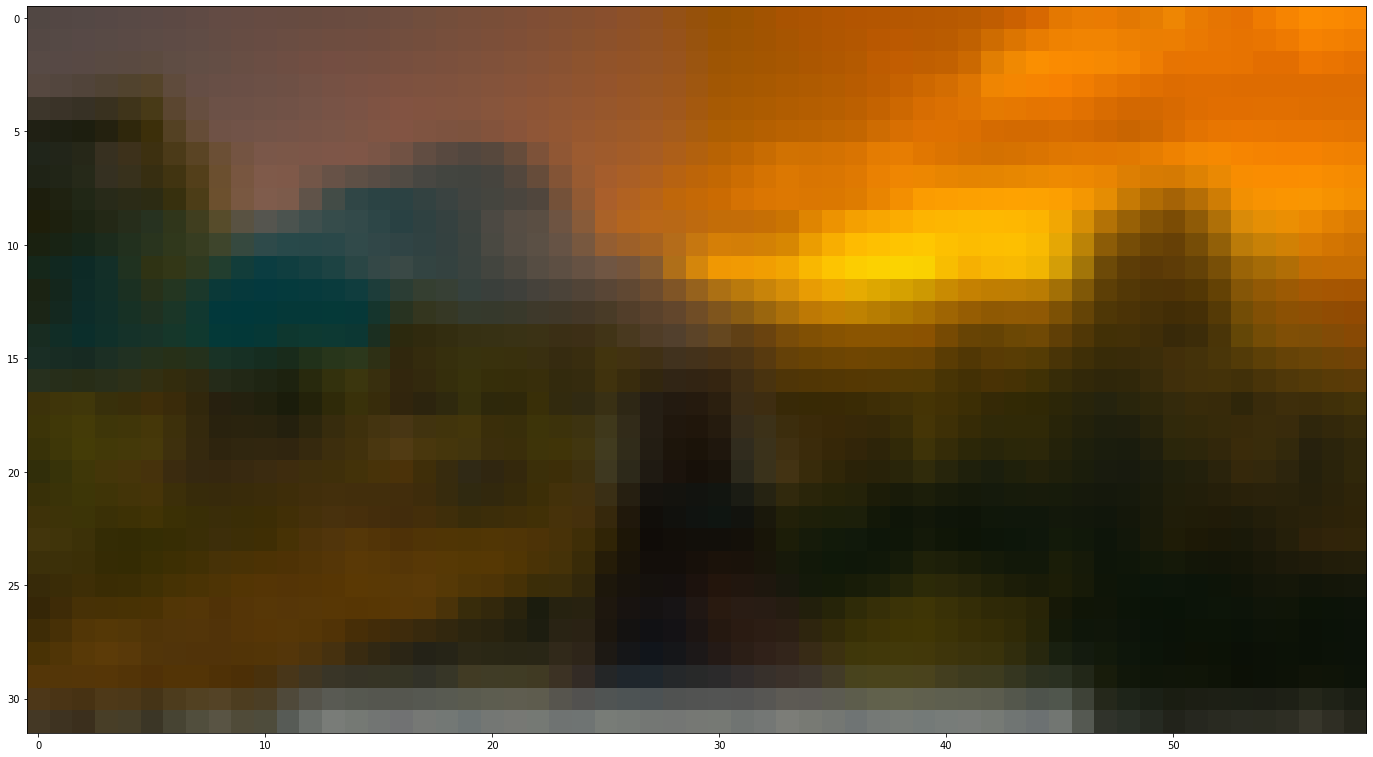

In [313]:
image_ru = downupsample(image, 0.02)
plt.figure(figsize=(24,16))
plt.imshow(image_ru.cpu())
plt.show()

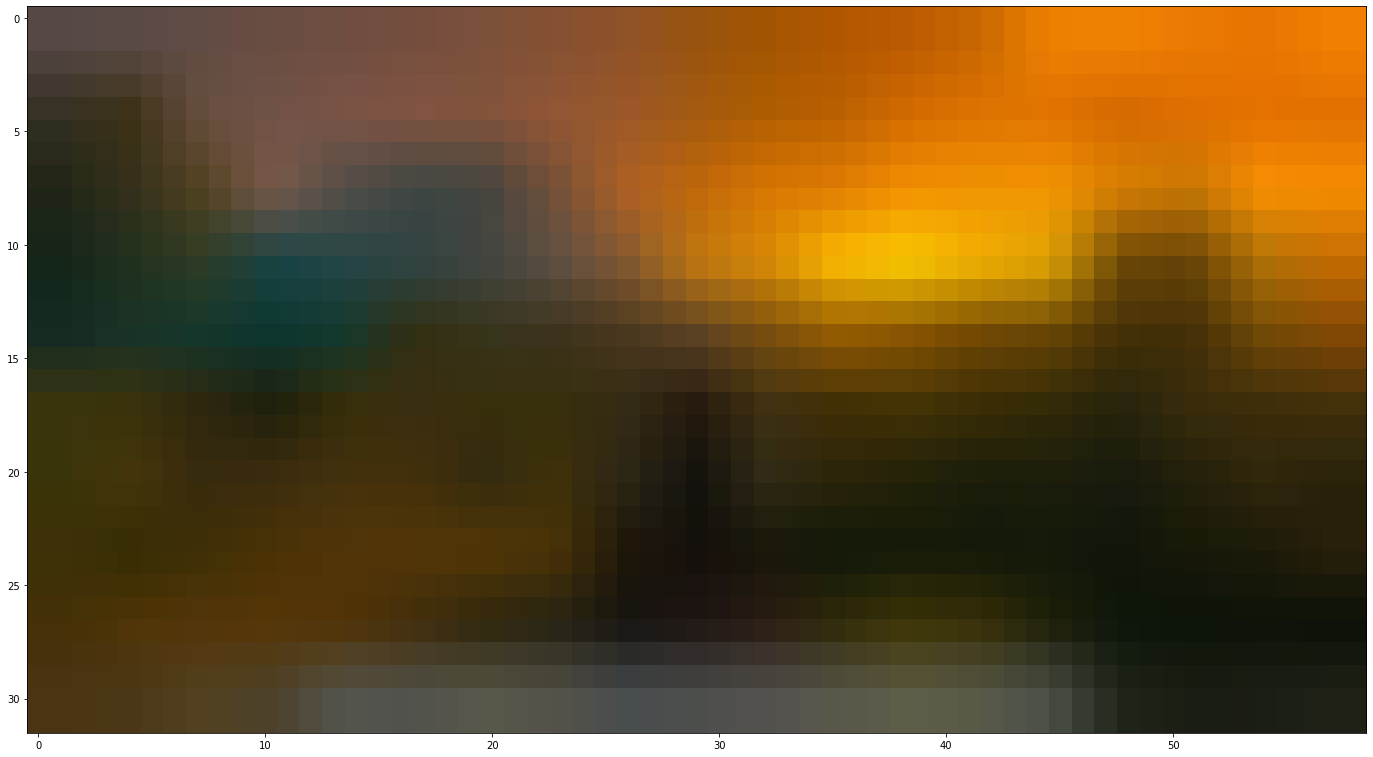

In [216]:
image_ru = downupsample(image, 0.01)
plt.figure(figsize=(24,16))
plt.imshow(image_ru.cpu())
plt.show()

# Benchmark something...

Permute / moveaxis

In [260]:
image_c = image.cpu().numpy()

In [261]:
image_c.shape

(1080, 1920, 3)

In [262]:
np.rollaxis(image_c, 2).shape

(3, 1080, 1920)

In [263]:
#Convert to numpy
benchmark('np.rollaxis(image.cpu().numpy(), 2)', 10)

Took 1.8488681000017095s
Took 1.8208622000020114s
Took 1.8712979999982053s
Took 1.8261127000005217s
Took 1.8559167999992496s
Took 1.8298433999989356s
Took 1.8957895999992616s
Took 1.896532599999773s
Took 1.8169417999997677s
Took 1.7701721000012185s
Totally: 18.432337300000654s
Avg: 1.8432337300000654s


In [264]:
#Input as numpy
benchmark('np.rollaxis(image_c, 2)', 10)

Took 0.0009734000013850164s
Took 0.0009092000000237022s
Took 0.0009117000008700415s
Took 0.0009544000022287946s
Took 0.000916299999516923s
Took 0.00097749999986263s
Took 0.0009152999991783872s
Took 0.0009124999996856786s
Took 0.0009600000012142118s
Took 0.0008992000002763234s
Totally: 0.009329500004241709s
Avg: 0.0009329500004241709s


In [265]:
benchmark('image.permute(2, 0, 1)', 10)

Took 1.0413851999983308s
Took 0.8560281999998551s
Took 0.8404364999987592s
Took 0.9322059000005538s
Took 0.8993115999983274s
Took 0.8849807999977202s
Took 0.9050239999996847s
Took 0.8730047999997623s
Took 0.8380006000006688s
Took 0.9408752000017557s
Totally: 9.011252799995418s
Avg: 0.9011252799995418s


## The whole operation

In [266]:
benchmark('image.permute(2, 0, 1).unsqueeze(0)', 10)

Took 1.7119641999997839s
Took 1.898653699998249s
Took 1.8425327000004472s
Took 1.7688573000014003s
Took 1.8555218000001332s
Took 2.0161594999990484s
Took 1.807465300000331s
Took 1.8406309999991208s
Took 1.9812430000019958s
Took 2.2331090000006952s
Totally: 18.956137500001205s
Avg: 1.8956137500001204s


In [267]:
benchmark('torch.from_numpy(np.expand_dims(np.rollaxis(image.cpu().numpy(), 2), axis=0))', 10)

Took 1.7974204000020109s
Took 1.7743655999984185s
Took 1.7732348000026832s
Took 1.8054785999993328s
Took 1.7982972000027075s
Took 1.779764000002615s
Took 1.7802886999998009s
Took 1.7717202999992878s
Took 1.7830673999997089s
Took 1.7773481000003812s
Totally: 17.840985100006947s
Avg: 1.7840985100006947s


In [268]:
# input as numpy
benchmark('torch.from_numpy(np.expand_dims(np.rollaxis(image_c, 2), axis=0))', 10)

Took 0.00275560000227415s
Took 0.0024549000008846633s
Took 0.0024282000013045035s
Took 0.002332700001716148s
Took 0.002384799998253584s
Took 0.0022967000004427973s
Took 0.002434200003335718s
Took 0.002336899997317232s
Took 0.00236889999723644s
Took 0.002205500000854954s
Totally: 0.02399840000362019s
Avg: 0.002399840000362019s


## numpy version of downupsample

In [306]:
def downupsample_n(array, scale, size=(32,59)):
    """source tensor should be in 3D (H, W, C) tensor"""
    # interpolate accept size of (B, C, H, W) while B is the batch size, only 1
    return F.interpolate(
        F.interpolate(
            torch.from_numpy(
                np.expand_dims(
                    np.rollaxis(array, 2),
                    axis=0)
            ),
            scale_factor=scale,
            mode='area'
        ),
        size=size,
        mode='bilinear',
        align_corners=False
    )

In [307]:
benchmark('downupsample_n(image_c, 0.01)', 10)

Took 2.8973702999974194s
Took 2.817747099998087s
Took 2.869186100000661s
Took 2.9149133000028087s
Took 2.807680199999595s
Took 2.7471018999967782s
Took 2.7214644999985467s
Took 2.7609950000005483s
Took 2.5483081999991555s
Took 2.4942593999985547s
Totally: 27.579025999992155s
Avg: 2.7579025999992153s


In [308]:
tensor = downupsample_n(image_c, 0.01)[0]
tensor.shape

torch.Size([3, 32, 59])

In [309]:
benchmark('tensor.cpu().numpy()', 10)

Took 0.03155880000122124s
Took 0.001169099999970058s
Took 0.001322300002357224s
Took 0.1814434000007168s
Took 0.1039533000002848s
Took 0.026807099999132333s
Took 0.1036301000021922s
Took 0.0011880999991262797s
Took 0.18126130000018748s
Took 0.026644699999451404s
Totally: 0.6589782000046398s
Avg: 0.06589782000046399s


## Let's try to blur it

In [96]:
!pip install kornia

In [97]:
import kornia

In [316]:
box_blur = kornia.filters.BoxBlur((7,7))
gauss_blur = kornia.filters.GaussianBlur2d((11, 11), (3, 3))

In [294]:
# as BCHW format
image_r_b = image_r.permute(2, 0, 1).unsqueeze(0)
image_r_b.shape

torch.Size([1, 3, 32, 59])

In [317]:
box_blurred_image = box_blur(image_r_b)[0].permute(1, 2, 0)
gauss_blurred_image = gauss_blur(image_r_b)[0].permute(1, 2, 0)

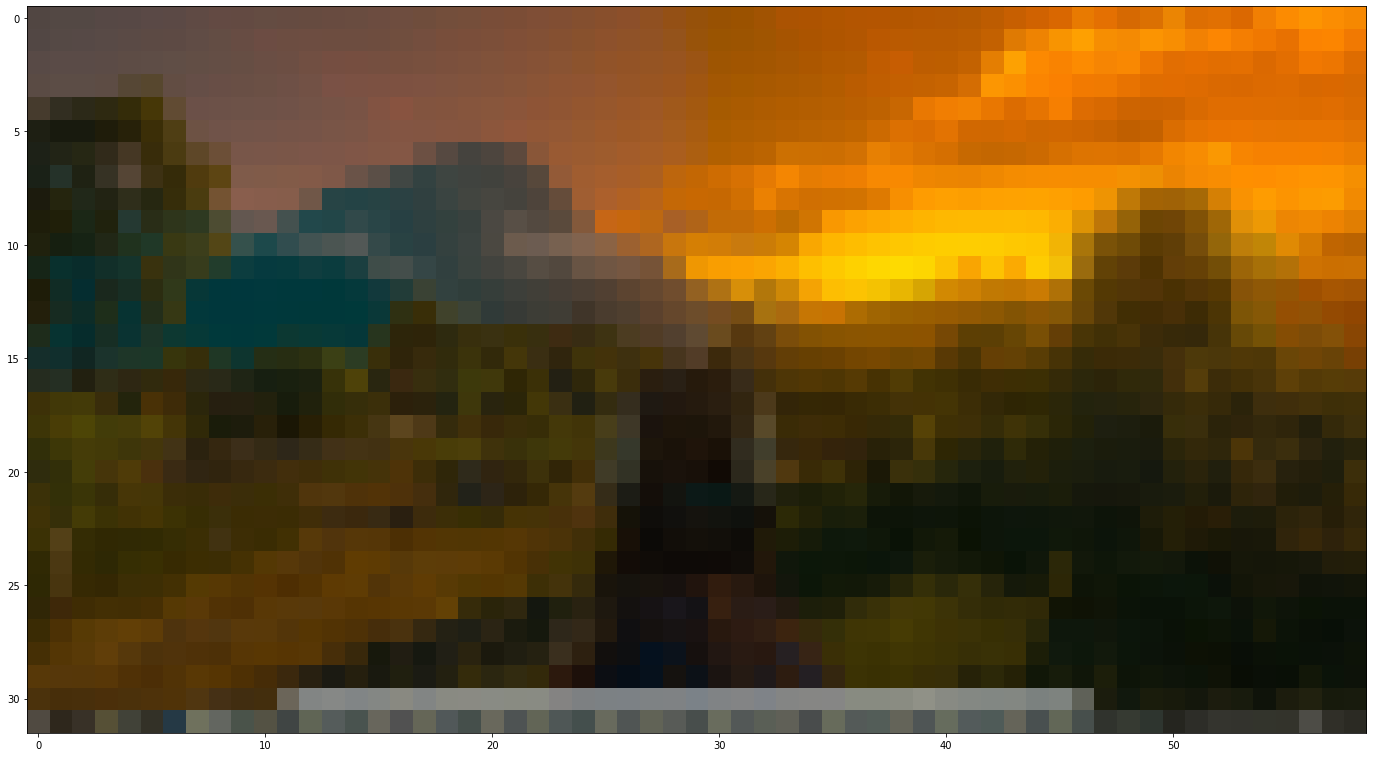

In [310]:
# Before
plt.figure(figsize=(24,16))
plt.imshow(image_r.cpu())
plt.show()

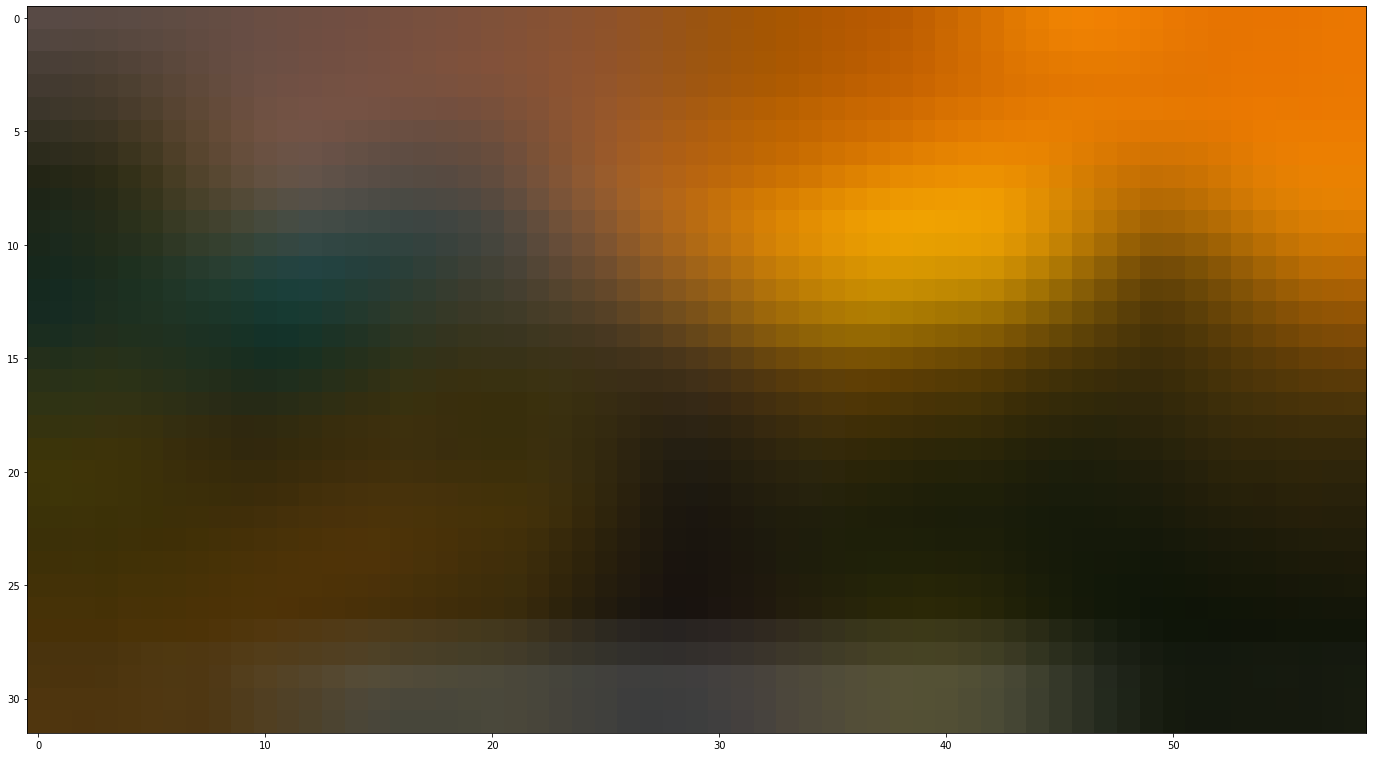

In [311]:
# After
plt.figure(figsize=(24,16))
plt.imshow(box_blurred_image.cpu())
plt.show()

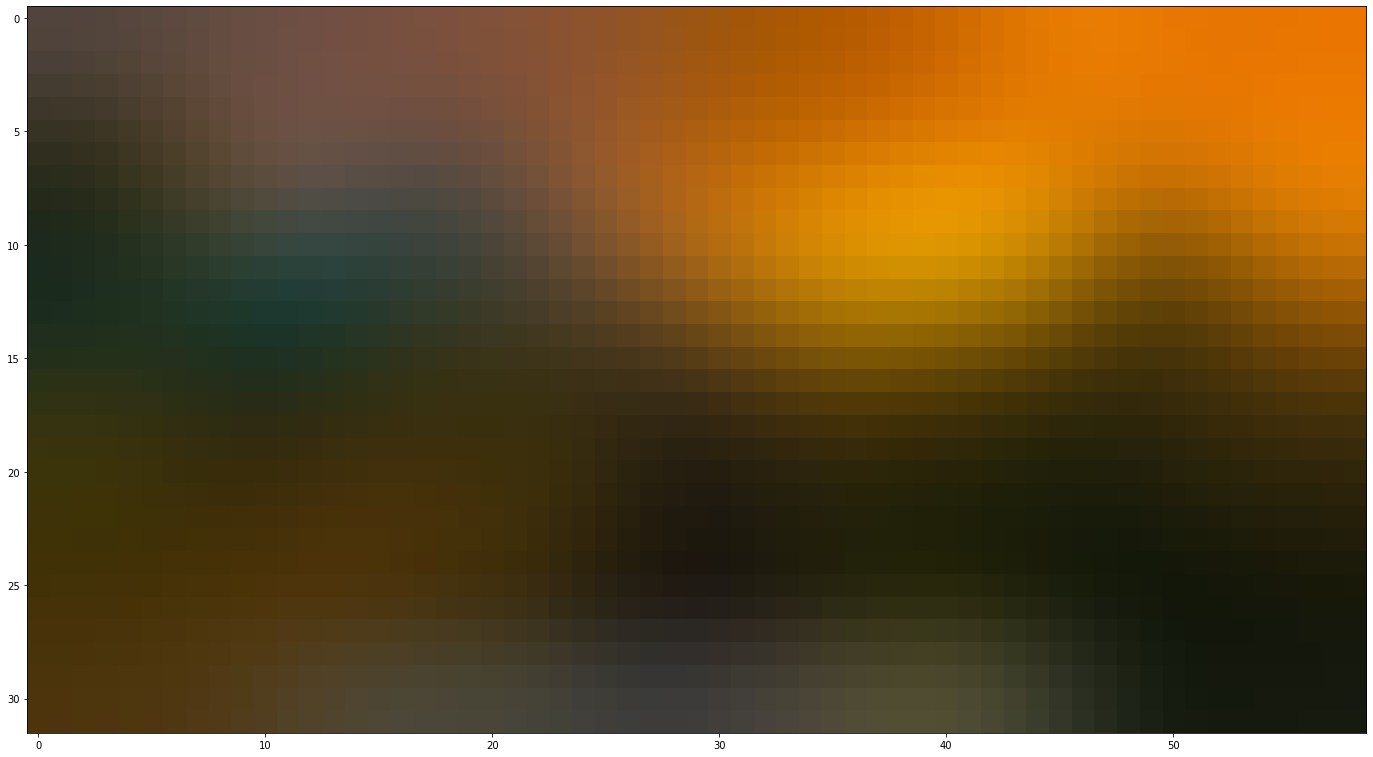

In [318]:
# After
plt.figure(figsize=(24,16))
plt.imshow(gauss_blurred_image.cpu())
plt.show()

## Similar result as downsample more and upscale

In [297]:
benchmark('box_blur(image_r_b)', 10)

Took 7.831697400000849s
Took 7.808021800003189s
Took 7.599903999998787s
Took 7.638277400001243s
Took 7.662197300000116s
Took 7.531867000001512s
Took 7.592582799999946s
Took 7.800494900002377s
Took 7.666313900001114s
Took 7.738794799999596s
Totally: 76.87015130000873s
Avg: 7.687015130000873s


In [319]:
benchmark('gauss_blur(image_r_b)', 10)

Took 7.704403700001421s
Took 7.69825999999739s
Took 7.622079199998552s
Took 7.671628000000055s
Took 7.736215000000811s
Took 7.641032500003348s
Took 7.749932499998977s
Took 7.659566500002256s
Took 7.708751300000586s
Took 7.777696699999069s
Totally: 76.96956540000247s
Avg: 7.696956540000246s


### Takes too long..., even unoptimzed version of the whole downupsample takes similar time